# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [85]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [87]:
# For reproducibility
torch.manual_seed(314)
np.random.seed(314)

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [88]:
# Define transforms
# Do some random transformations while training for a better generalization
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_valid_data = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=train_transforms)
test_data = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=test_transforms)

train_size = int(np.floor(0.8 * len(train_valid_data)))
valid_size = len(train_valid_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_valid_data, [train_size, valid_size])
    
# Create dataloader
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [89]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
        image = images[i] / 2 + 0.5
        image = image.numpy()
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.show()

bird


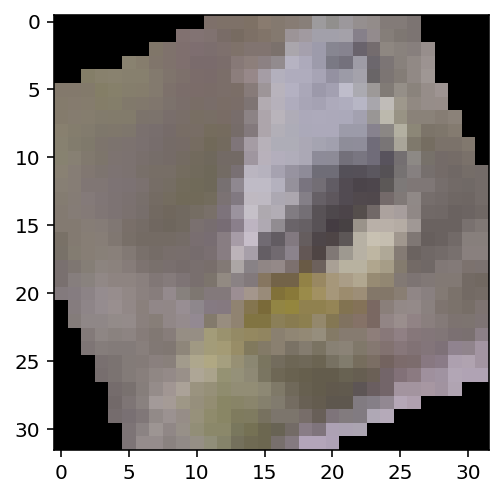

deer


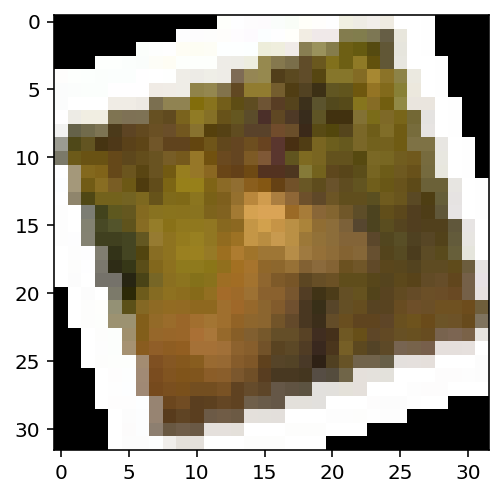

horse


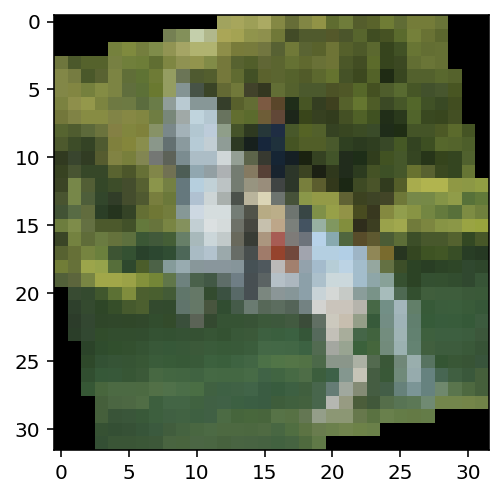

deer


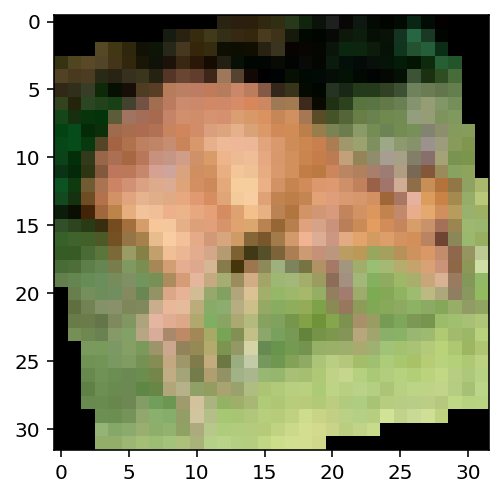

deer


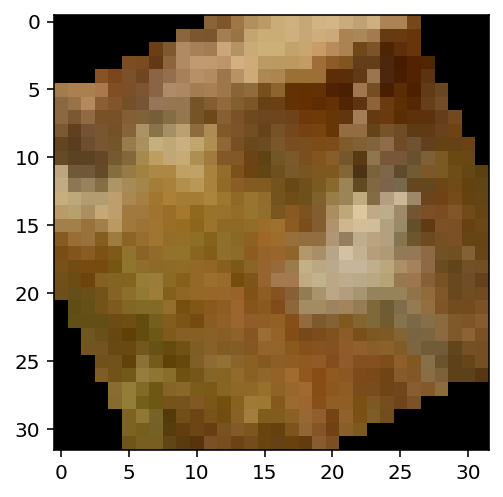

horse


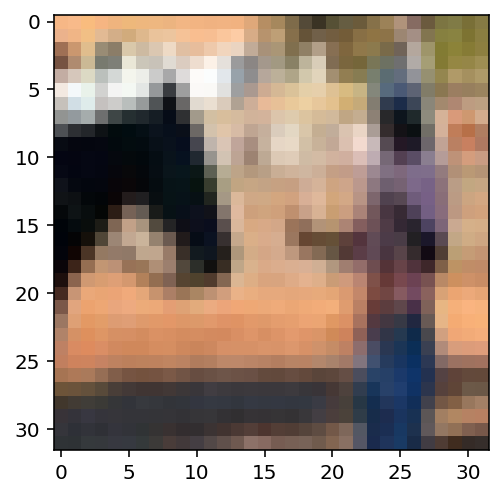

cat


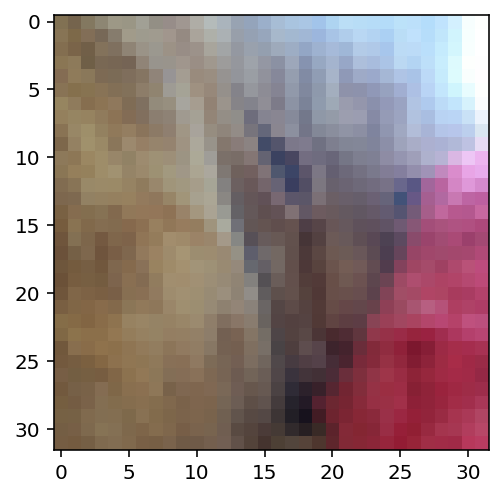

bird


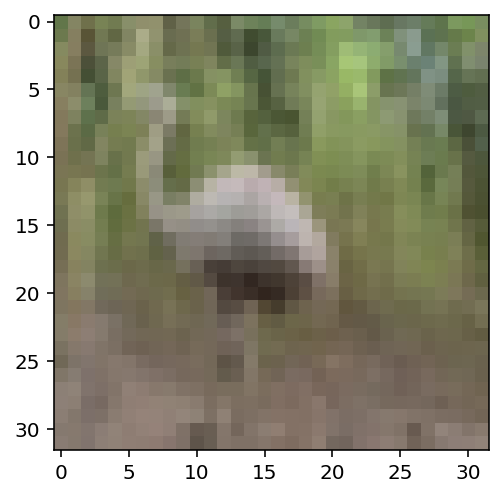

bird


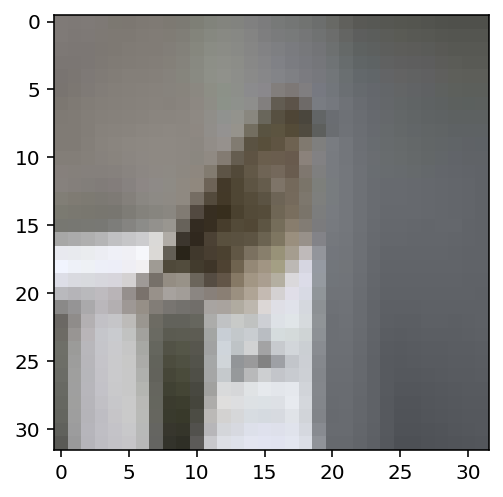

deer


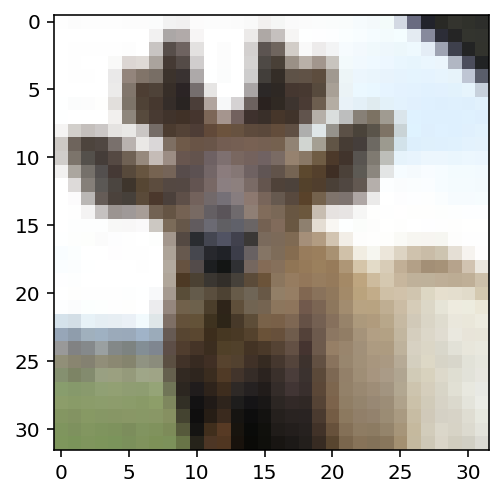

In [90]:
# Explore data
show5(trainloader)
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [91]:
# inspired by
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# https://stackoverflow.com/questions/66849867/understanding-input-and-output-size-for-conv2d
# https://towardsdatascience.com/classify-your-images-using-convolutional-neural-network-4b54989d93dd
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # convolutional layer (sees 32x32x3 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # convolutional layer (sees 16x16x16 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # convolutional layer (sees 8x8x32 tensor)
        self.pool = nn.MaxPool2d(2, 2) # max pooling layer, reduces images size by a half after applying it
        self.fc1 = nn.Linear(64 * 4 * 4, 512) # linear layer 64 output channels * image size 4x4 after applying 3 times MaxPool2d
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4) # flatten image input
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [92]:
model = Net()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);
print(f'training on device {device}')

epochs = 200
min_valid_loss = np.Inf # track change in validation loss
train_log = {
    "train_losses" : list(),
    "valid_losses" : list(),
    "valid_accuracy" : list()
}
for epoch in range(epochs):
    #######################
    # Training            #
    #######################
    train_loss = 0
    for inputs, labels in trainloader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    #######################
    # Validation          #
    #######################
    valid_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            valid_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    model.train()

    #######################
    # Logging             #
    #######################
    avg_train_loss = train_loss/len(trainloader)
    avg_valid_loss = valid_loss/len(validloader)
    avg_valid_acc = accuracy/len(validloader)
    train_log["train_losses"].append(avg_train_loss)
    train_log["valid_losses"].append(avg_valid_loss)
    train_log["valid_accuracy"].append(avg_valid_acc)
    print(f"Epoch {epoch+1:03d}/{epochs:03d}.. "
          f"Train loss: {avg_train_loss:.3f}.. "
          f"Valid loss: {avg_valid_loss:.3f}.. "
          f"Valid accuracy: {avg_valid_acc:.3f}")
        
    #######################
    # Saving best model   #
    #######################
    if avg_valid_loss < min_valid_loss:
        print(f"found a better model, saving...")
        torch.save(model.state_dict(), 'model.pt')
        min_valid_loss = avg_valid_loss
    

training on device cuda
Epoch 001/200.. Train loss: 1.655.. Valid loss: 1.404.. Valid accuracy: 0.485
found a better model, saving...
Epoch 002/200.. Train loss: 1.362.. Valid loss: 1.304.. Valid accuracy: 0.534
found a better model, saving...
Epoch 003/200.. Train loss: 1.252.. Valid loss: 1.183.. Valid accuracy: 0.579
found a better model, saving...
Epoch 004/200.. Train loss: 1.189.. Valid loss: 1.150.. Valid accuracy: 0.594
found a better model, saving...
Epoch 005/200.. Train loss: 1.142.. Valid loss: 1.087.. Valid accuracy: 0.616
found a better model, saving...
Epoch 006/200.. Train loss: 1.112.. Valid loss: 1.062.. Valid accuracy: 0.628
found a better model, saving...
Epoch 007/200.. Train loss: 1.075.. Valid loss: 1.060.. Valid accuracy: 0.621
found a better model, saving...
Epoch 008/200.. Train loss: 1.051.. Valid loss: 1.021.. Valid accuracy: 0.639
found a better model, saving...
Epoch 009/200.. Train loss: 1.032.. Valid loss: 1.036.. Valid accuracy: 0.634
Epoch 010/200.. Tr

Epoch 096/200.. Train loss: 0.749.. Valid loss: 0.855.. Valid accuracy: 0.718
Epoch 097/200.. Train loss: 0.741.. Valid loss: 0.879.. Valid accuracy: 0.710
Epoch 098/200.. Train loss: 0.741.. Valid loss: 0.885.. Valid accuracy: 0.712
Epoch 099/200.. Train loss: 0.741.. Valid loss: 0.900.. Valid accuracy: 0.714
Epoch 100/200.. Train loss: 0.744.. Valid loss: 0.842.. Valid accuracy: 0.716
Epoch 101/200.. Train loss: 0.733.. Valid loss: 0.878.. Valid accuracy: 0.715
Epoch 102/200.. Train loss: 0.742.. Valid loss: 0.869.. Valid accuracy: 0.710
Epoch 103/200.. Train loss: 0.738.. Valid loss: 0.853.. Valid accuracy: 0.715
Epoch 104/200.. Train loss: 0.732.. Valid loss: 0.885.. Valid accuracy: 0.714
Epoch 105/200.. Train loss: 0.743.. Valid loss: 0.840.. Valid accuracy: 0.732
Epoch 106/200.. Train loss: 0.731.. Valid loss: 0.865.. Valid accuracy: 0.716
Epoch 107/200.. Train loss: 0.736.. Valid loss: 0.844.. Valid accuracy: 0.727
Epoch 108/200.. Train loss: 0.735.. Valid loss: 0.861.. Valid ac

Epoch 199/200.. Train loss: 0.710.. Valid loss: 0.858.. Valid accuracy: 0.723
Epoch 200/200.. Train loss: 0.698.. Valid loss: 0.839.. Valid accuracy: 0.724


Plot the training loss (and validation loss/accuracy, if recorded).

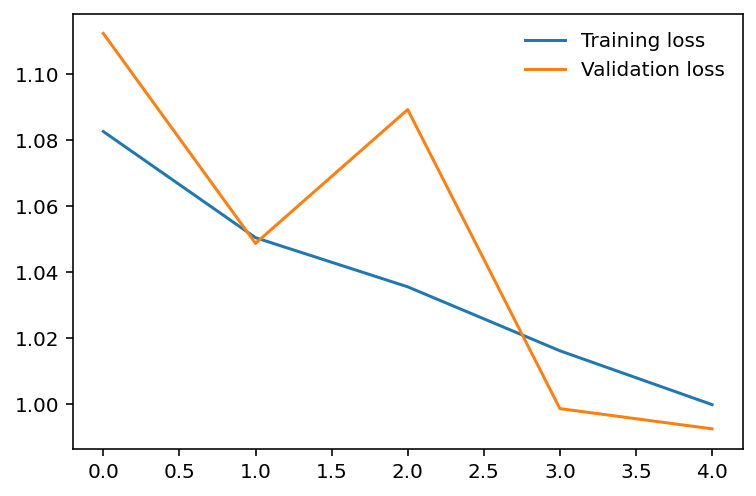

In [59]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_log["train_losses"], label='Training loss')
plt.plot(train_log["valid_losses"], label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [84]:
# load the best model 
state_dict = torch.load('model.pt')
best_model = Net()
best_model.load_state_dict(state_dict)
best_model.to(device)

test_accuracy = 0

best_model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = best_model.forward(inputs)
        
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    print(f"Test accuracy: {test_accuracy/len(testloader):.3f}")


Test accuracy: 0.678


## Saving your model
Using `torch.save`, save your model for future loading.

In [127]:
# see above

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

I recommend to take the custom model developed in this notebook.
Resons: Currently the models perform similar (regarding accuracy). So it would be cheaper to take our model instead of purchasing a new one. In addition we have full control over further development of the model and we can tune it best for our needs. In case Detectocorp’s model will evolve faster and gets a lot better than our custom model, we can then still decide to switch to that model. 
